# Markov Chain Monte Carlo 

With the aid and mentorship from my dear friend, *Peter C. Manefeldt*

In [1]:
library(ggplot2)

#### MCMC (estimation for known distribution parameters)

In [2]:
mcmc_known <- function(px, Mgx, x0){

    # where px = true distribution
    # Mgx = distribution to be sampled from, greater than px
    # x0 is a starting value 


    # empty vector necessary for the for loop
    accepted <- c()


    # For loop, introducing the computation of the acceptance-rejection method for the monte carlo markov chain 

        for(i in 1:10^4){
            
            x1 <- Mgx(x0)# proposed starting point applied to prior 
            AR_ratio <- ifelse((px(x1)/px(x0)) > 1, 1,px(x1)/px(x0)) # calculating the ratio 
            # the above ratio is representative of the probability of accepting a sample

            # if the ratio is greater than a random uniform sample, set the value as x1 (prior applied to starting value) -
            accepted[i] <- ifelse(runif(1) < AR_ratio, x1, x0)
    
            # The markov chain: learn from previously accepted sample: 
            x0 <- accepted[i] # the above value, if accepted, then becomes the new starting value 

        }



# plotting the above 
# plotting to show the learning of the mu parameter 
dat <- data.frame(accepted)
plot1 <- ggplot(dat) + 
geom_line(aes(x = c(1:10^4), y = accepted)) + 
theme_bw(base_size = 20) +
labs(x = "Index", y =  "Samples")


# plotting the posterior distribution 
dat2 <- data.frame(cbind(dat, px(c(1:10^5))))
colnames(dat2) <- c('Posterior', 'True')
plot2 <- ggplot(dat2) +
geom_density(aes(x = Posterior))+
theme_bw(base_size = 20) 



list(plot1, plot2)


}
 







[[1]]

[[2]]


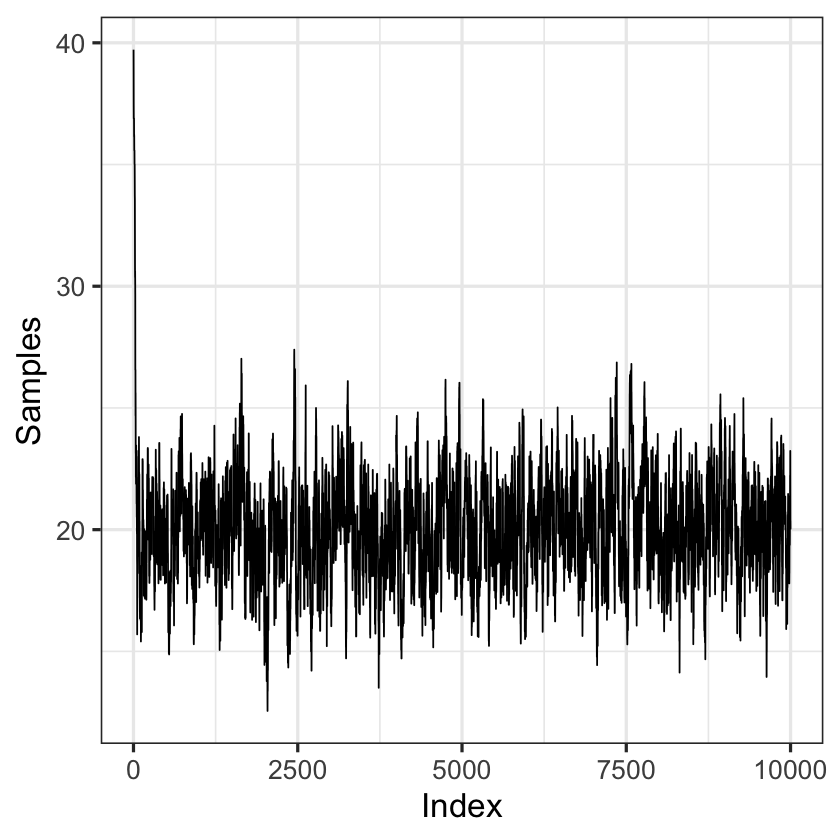

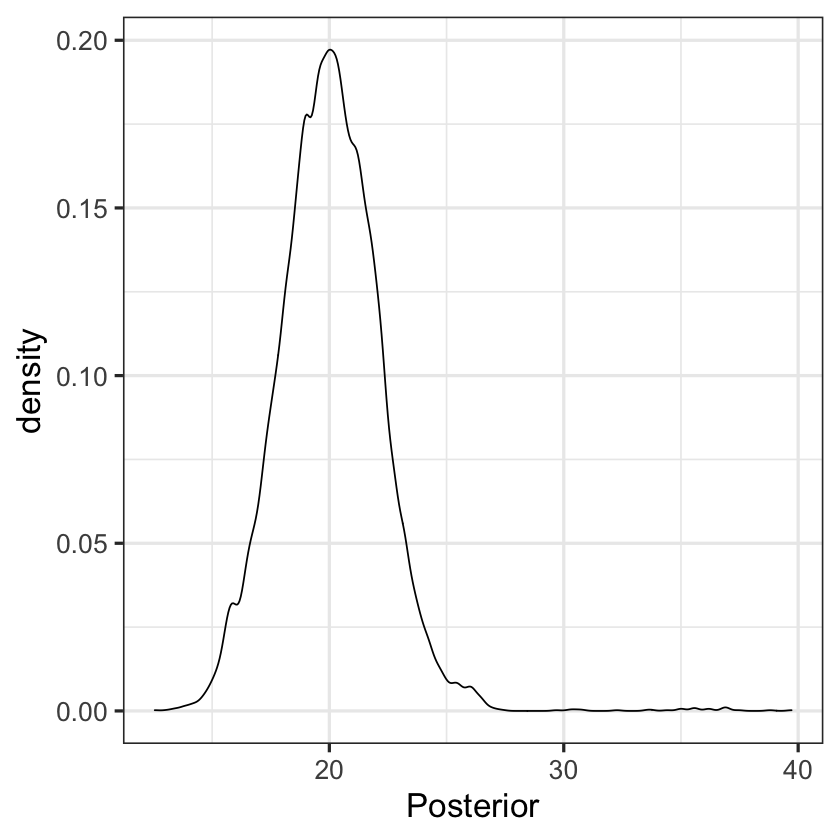

In [3]:
target_dist <- function(x){
    (1/sqrt(2*pi*2^2))*exp((-(x-20)^2)/(2*2^2))
}



proposed_dist <- function(x){
    rnorm(1, mean = x, sd = 1)
}





mcmc_known(target_dist, proposed_dist, 40)


# MCMC
#### Estimation for unknown distribution parameters


$
\begin{align}
P(\theta|x) = \frac{P(x|\theta)P(\theta)}{P(x)}
\end{align}
$

Above is Bayes formula. Our posterior $P(\theta|x)$, the probability of observing the model parameters, $\theta$ given data $x$ is derived by multiplying the prior $P(\theta)$ (Representative of what we think about $\theta$ before seeing any of the data) and the likelihood, $P(x|\theta)$  (how we expect our data to be distributed).

You could intuitively solve the denominator (ie the marginal likelihood) by just integrating over all possible parameter values. But this is the shortfall of Bayes, when the model becomes even slightly complicated- this computation becomes intractable. So to solve it we need to approximate it, but in a way that we can skip the computation of (1). Thus, we introduce MCMC - Markov Chain Monte Carlo. 

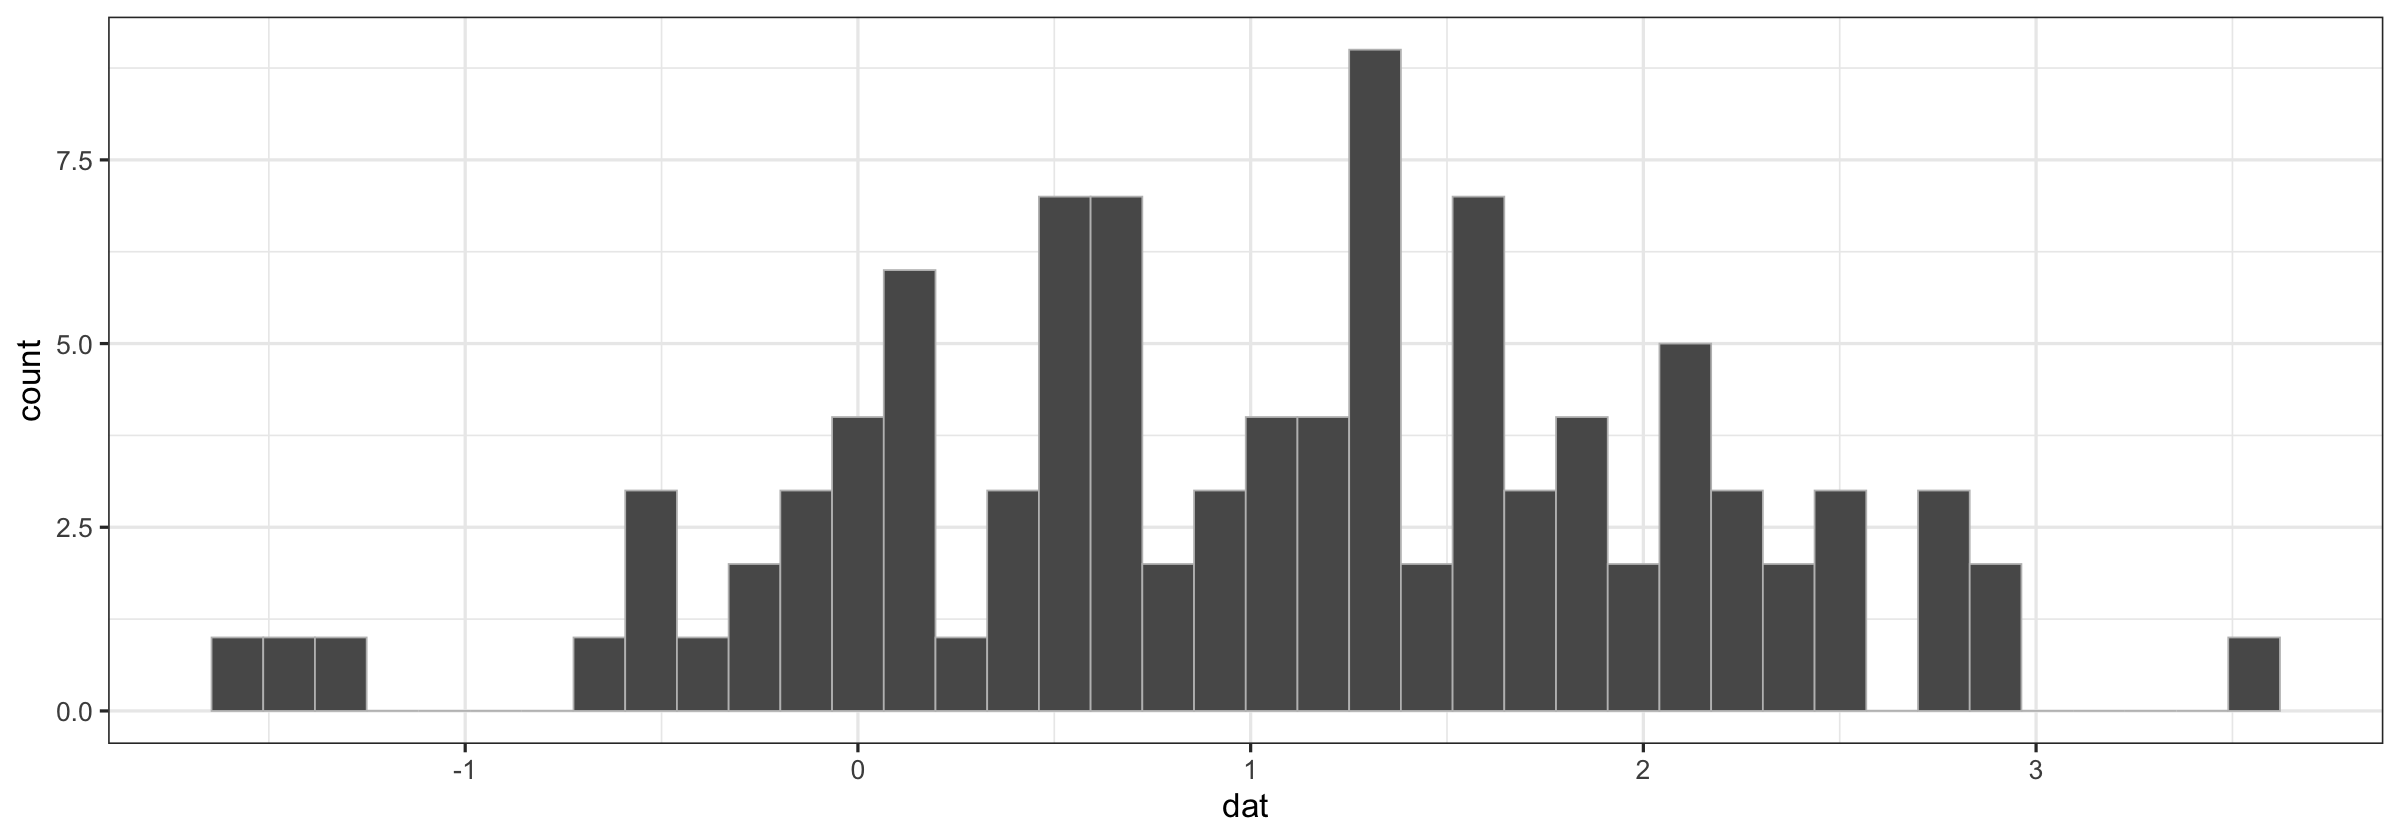

In [255]:
dat <- rnorm(100, mean = 1, sd = 1)
par(bg = 'white')

ggplot(data.frame(dat)) + 
geom_histogram(aes(x =dat), bins = 40, col = "grey") +
theme_bw(base_size = 20) 

We are working with a joint posterior distribution because of the nature of multiple parameters, forming a vector, $\theta$. We are trying to measure the distribution of those parameters conditioned upon some data (observational constraints). A simplistic way to think of why we are trying to infer the posterior: We are trying to get a credible interval of the parameters of interest.

In MCMC we are just trying to get the posterior. The normalisation factor (ie marginal likelihood) makes no difference and can in essence be taken out. This then means that the posterior distribution is proportional to the likelihood and the prior:

$$
\begin{align}
P(\theta |x) \propto P(x|\theta)P(\theta)
\end{align}
$$


The process of MCMC involves observing the data, and generate different $\theta's$ that its going to want to try it. That is going to give a prior probability of those thetas are. The theta is going to be applied as a parameter to the model and that, in return is going to return the likelihood of that particular choice of parameter. The likelihood is then going to multiplied by the prior to evaluate the posterior probability for that particular choice. 


[[1]]

[[2]]


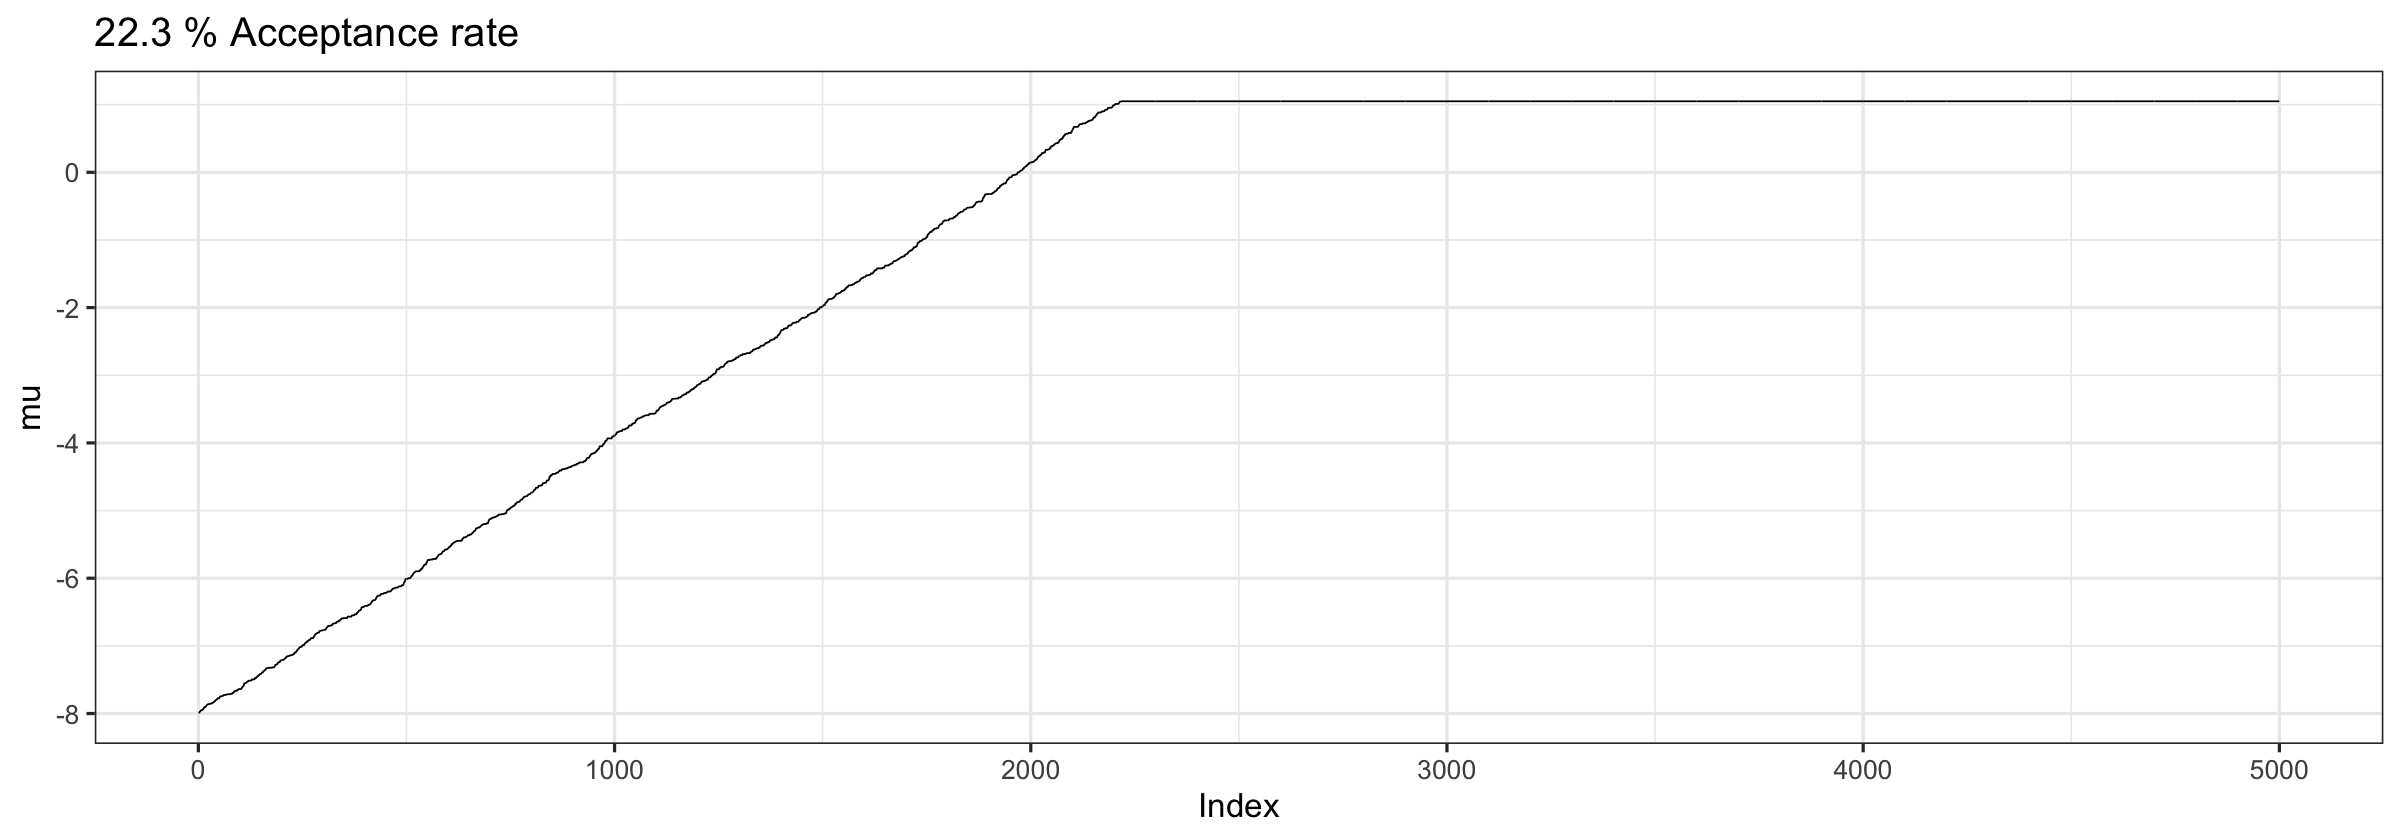

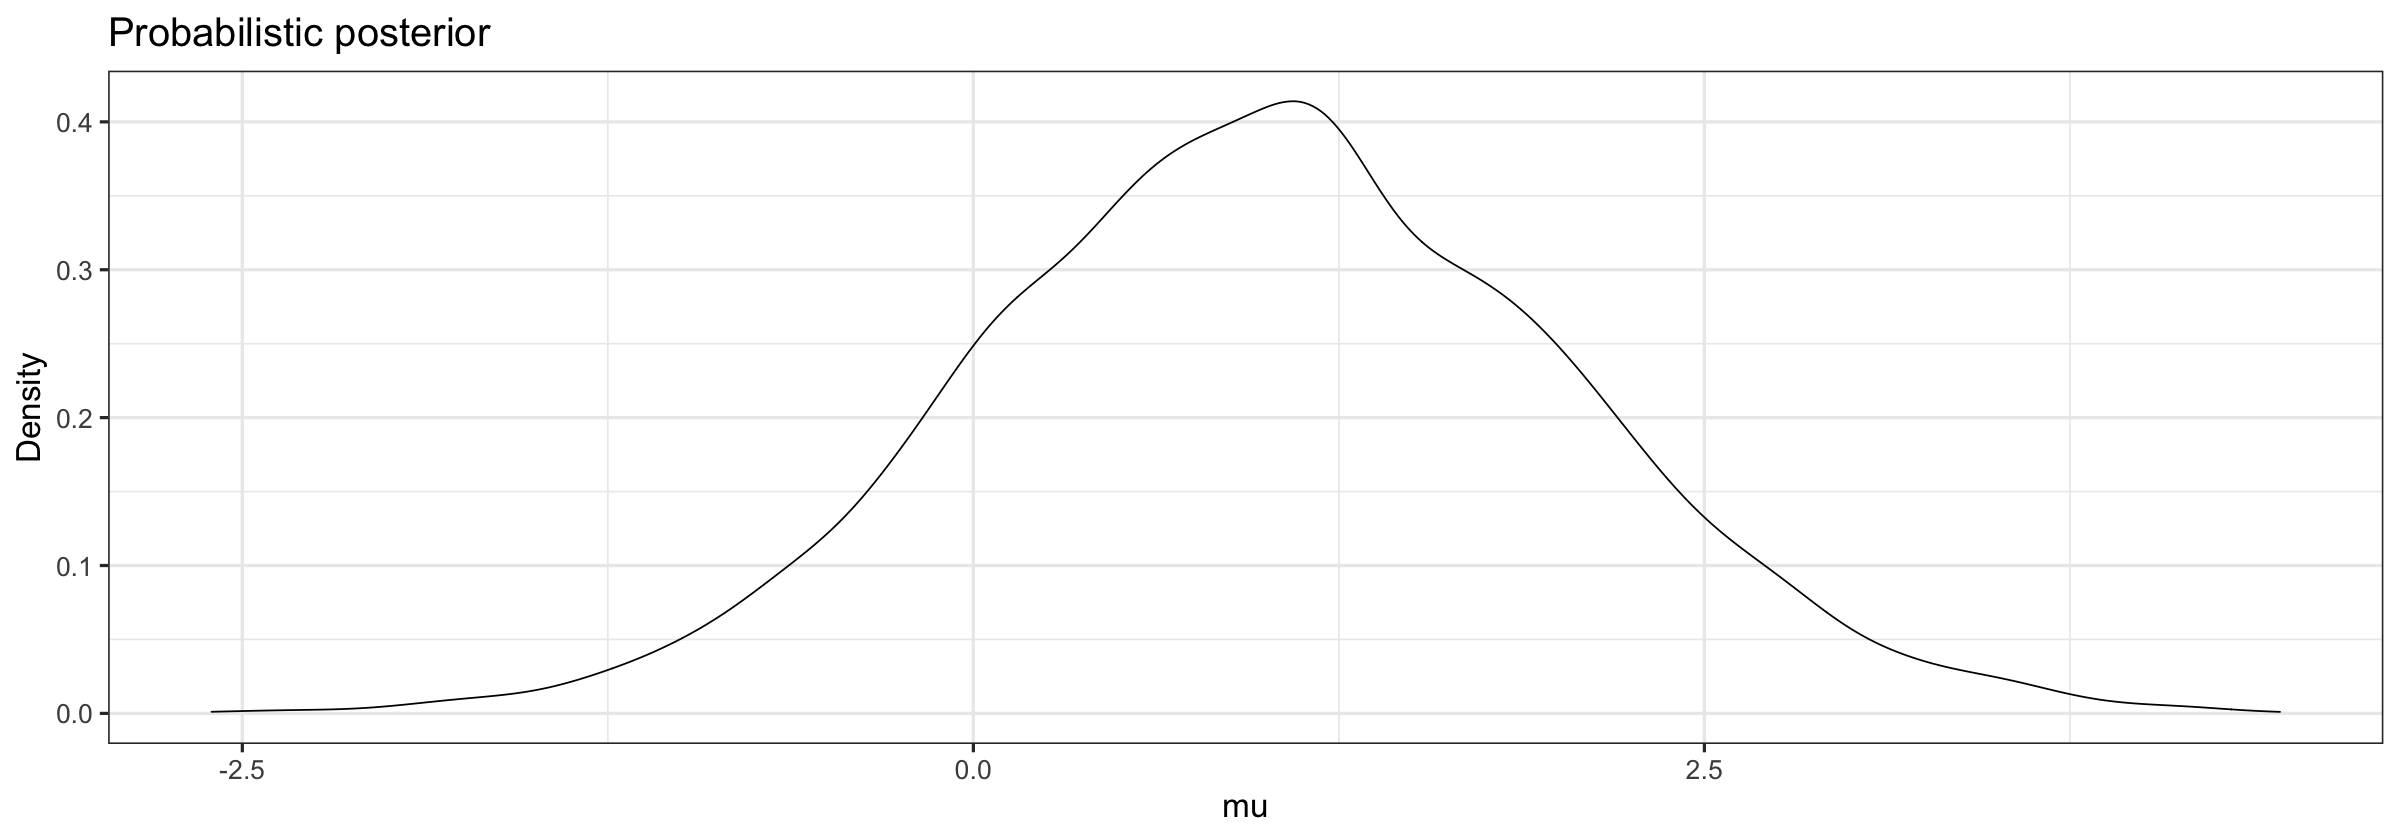

In [413]:
mcmc_bayes <- function(theta, data, jump){

########################################################################################################
# Posterior distribution probability calculation 
########################################################################################################

    # function providing the posterior probability (with the inclusion of a suggested prior)
        posterior <- function(theta, data = dat){
            # below is log computed otherwhise the probabilities are too small  
            likelihood <- sum(log(dnorm(data, mean = theta, sd = 1))) # likelihood function 
            prior <- log(dnorm(theta, 0, 100)) # suggested prior 
            # because we know that the posterior is proportional to the prior and the likelihood 
            post <- likelihood + prior # keeping in mind the product of the likelihood and the prior turns into a summation because of the log computation
            post
        }



    accepted <- c()
    iters <- 5000

########################################################################################################
# MCMC 
########################################################################################################

    # for-loop for the markov chain monte-carlo 
        for(i in 1:iters){

            theta_current <- rnorm(1, mean = theta, sd =jump)
            
            # if the posterior probability of the proposed theta is greater than the current theta, make the AR (Acceptance-Rejection) ratio = 1
            # Otherwise, create (using a binomial) the probability of accepting a sample (note, because posteriors were computed logarithmically, we have to undo that using exp)
            AR_ratio <- ifelse((posterior(theta_current)) > (posterior(theta)), 1, rbinom(1, size = 1, prob = exp(posterior(theta_current - theta))))


            # if the AR ratio is greater than a random uniform sample, accept the newly proposed theta value 
            accepted[i] <- ifelse(runif(1) < AR_ratio, theta_current, theta)
            
            # The markov chain: learn from previously accepted sample: 
            theta <- accepted[i] # the above value, if the newly proposed theta is accepted, it becomes the new starting theta 

        }


# calculating an MCMC acceptance rate 
accept_rate <- round((length(unique(accepted))/iters)*100, 3)


########################################################################################################
# Plots
########################################################################################################

# plotting the learning curve of the above
options(repr.plot.width = 20)
accepted_dat <- data.frame(accepted)
    
    plot1 <- ggplot(accepted_dat) + 
            geom_line(aes(x = c(1:iters), y = accepted)) + 
            theme_bw(base_size = 20) +
            labs(x = "Index", y =  "mu")+
            ggtitle(paste(accept_rate,"% Acceptance rate"))


# plotting the posterior distribution 
postdat <- data.frame(rnorm(iters, mean = accepted[iters], sd = 1))
colnames(postdat) <- c('x')

    plot2 <- ggplot(postdat)+
            geom_density(aes(x = x))+
            theme_bw(base_size = 20)+
            labs(x = "mu", y = 'Density')+
            ggtitle("Probabilistic posterior")
            
            
# returning the outputs 
list(plot1, plot2)

}




####################################################
# Running the function 
####################################################


mcmc_bayes(theta = -8, dat, jump = 0.01)